In [ ]:
!wget -o "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install split-folders


In [ ]:
import splitfolders
splitfolders.ratio("/content/Plant_leave_diseases_dataset_with_augmentation",output="dataset",seed=1337,ratio=(.8,.1,.1))

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


BATCH_SIZE=32
IMG_SIZE=(160,160)

train_dir="/content/dataset/train"
val_dir="/content/dataset/val"
test_dir="/content/dataset/test"

train_dataset=tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)



Found 49179 files belonging to 39 classes.


In [ ]:
validation_dataset=tf.keras.utils.image_dataset_from_directory(val_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
test_dataset=tf.keras.utils.image_dataset_from_directory(test_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


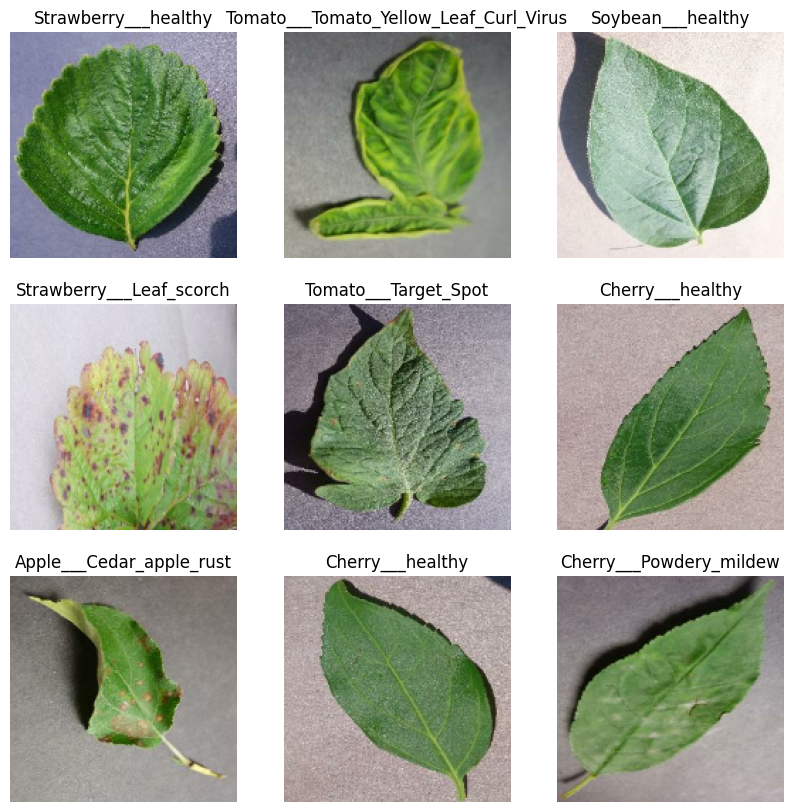

In [ ]:
class_names=train_dataset.class_names
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')



In [ ]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=AUTOTUNE)



In [ ]:
IMG_SHAPE=IMG_SIZE+(3,)

base_model=tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    include_preprocessing=True
)

base_model


In [ ]:
base_model.trainable=False
base_model.summary()


Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 160, 160,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 80, 80,    │        432 │ rescaling_5[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 80, 80,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 80, 80,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ activation_100[0… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_95 (ReLU)     │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        256 │ re_lu_95[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 80, 80,    │          0 │ activation_100[0… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_96 (ReLU)     │ (None, 80, 80,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 81, 81,    │          0 │ re_lu_96[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feautre_batch = base_model(image_batch)

In [ ]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feautre_batch_average=global_average_layer(feautre_batch)


In [ ]:
prediction_layer=tf.keras.layers.Dense(len(class_names),activation="sigmoid")
prediction_batch=preditction_layer(feautre_batch_average)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 39)             │        37,479 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,831 (11.57 MB)

 Trainable params: 37,479 (146.40 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
len(model.trainable_variables)

2

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy( name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.0185 - loss: 4.8311


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9763 - loss: 0.0698 - val_accuracy: 0.9769 - val_loss: 0.0786
Epoch 2/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step - accuracy: 0.9771 - loss: 0.0700 - val_accuracy: 0.9769 - val_loss: 0.0794
Epoch 3/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.9764 - loss: 0.0689 - val_accuracy: 0.9767 - val_loss: 0.0824
Epoch 4/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 74s 29ms/step - accuracy: 0.9779 - loss: 0.0642 - val_accuracy: 0.9744 - val_loss: 0.0808
Epoch 5/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9788 - loss: 0.0630 - val_accuracy: 0.9751 - val_loss: 0.0804
Epoch 6/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 87s 32ms/step - accuracy: 0.9793 - loss: 0.0625 - val_accuracy: 0.9769 - val_loss: 0.0768
Epoch 7/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.9775 - loss: 0.0635 - val_accuracy: 0.9788 - val_loss: 0.0771
Epoch 8/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9800 -

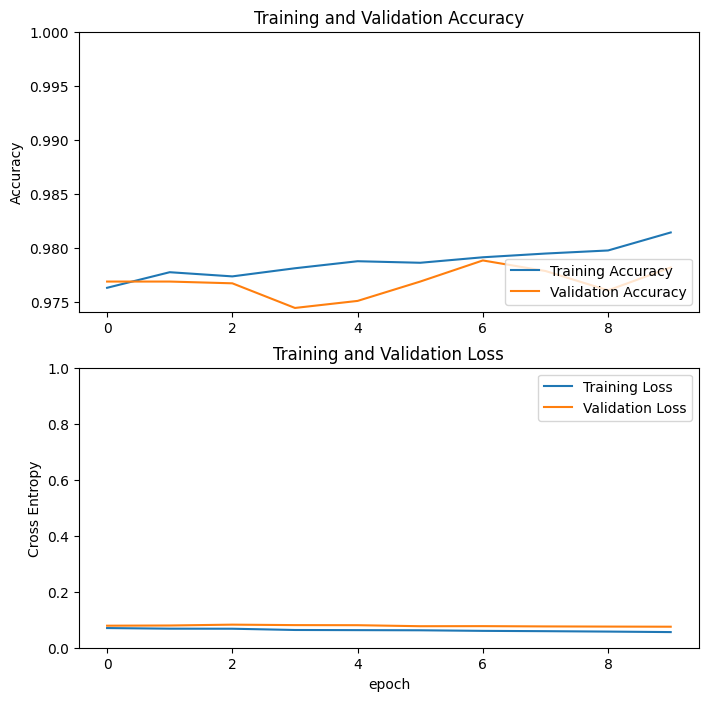

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  187


In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy( name='accuracy')])

In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 39)             │        37,479 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,831 (11.57 MB)

 Trainable params: 2,849,479 (10.87 MB)

 Non-trainable params: 184,352 (720.12 KB)

In [ ]:
len(model.trainable_variables)

79

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 113s 52ms/step - accuracy: 0.9065 - loss: 0.5608 - val_accuracy: 0.1924 - val_loss: 661.0632
Epoch 12/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.9701 - loss: 0.1068 - val_accuracy: 0.9787 - val_loss: 0.1059
Epoch 13/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - accuracy: 0.9811 - loss: 0.0590 - val_accuracy: 0.2518 - val_loss: 152.0232
Epoch 14/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.9795 - loss: 0.0710 - val_accuracy: 0.9832 - val_loss: 0.0752
Epoch 15/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.9863 - loss: 0.0429 - val_accuracy: 0.7386 - val_loss: 13.8038
Epoch 16/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9845 - loss: 0.0528 - val_accuracy: 0.9855 - val_loss: 0.0631
Epoch 17/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9892 - loss: 0.0323 - val_accuracy: 0.9837 - val_loss: 0.0848
Epoch 18/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accu

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

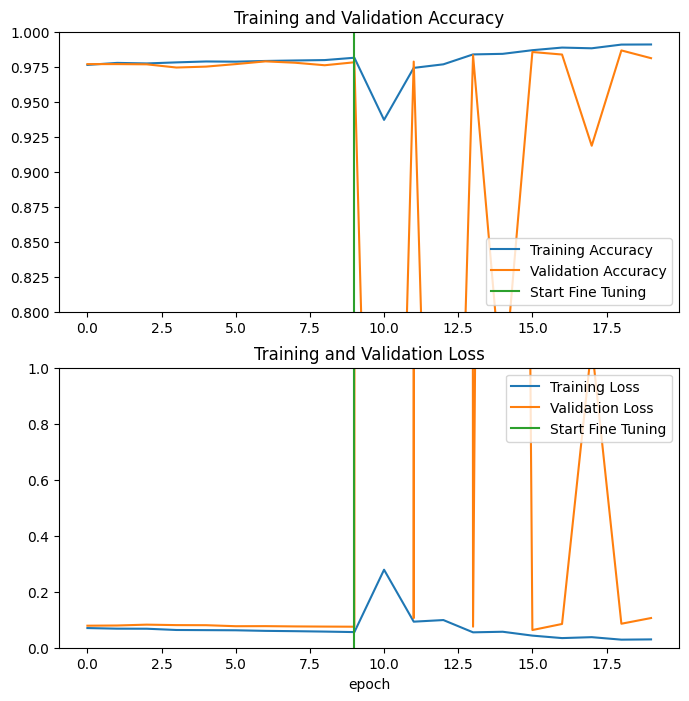

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9807 - loss: 0.0916
Test accuracy : 0.9781128168106079


Predictions:
 [32 36 21 15 16 11 19 12  0  1 29 33  3 37 37 25 36 25  3 15 13 14 11 17
  0  3 29 15  4 37 16 16]
Labels:
 [32 36 21 15 16 11 19 12  0  1 29 33  3 37 37 25 36 25  3 15 13 14 11 17
  0  3 29 15  4 37 16 16]


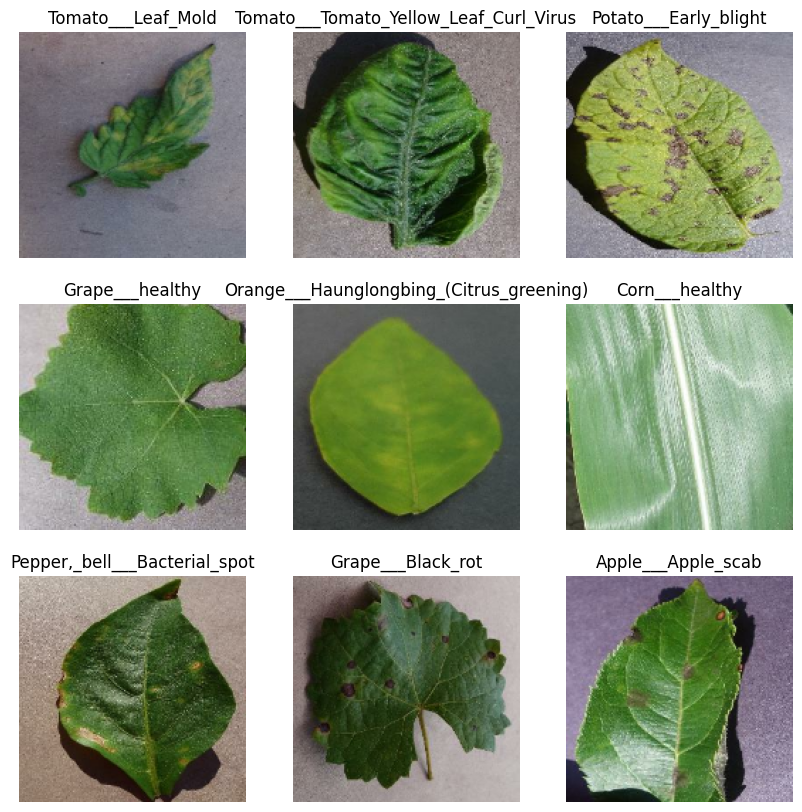

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# New Section

In [ ]:
model.save("plant_disease_detection.keras")

In [ ]:
model.save("/content/drive/MyDrive/plant_disease_detection.keras")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant = converter.convert()

with open("/content/drive/MyDrive/plant_disease_detection_quant.tflite", "wb") as f:
    f.write(tflite_quant)


Saved artifact at '/tmp/tmplf_g1rsm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_1220')
Output Type:
  TensorSpec(shape=(None, 39), dtype=tf.float32, name=None)
Captures:
  140687558774416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087496784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087498128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087497744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087497936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087495632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087496592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087497552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087497168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140686087499088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14068608

In [ ]:
img_path = "/content/dataset/test/Corn___Common_rust/image (1077).JPG"
img = tf.keras.utils.load_img(img_path, target_size=(160,160))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # create batch

predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0]).numpy()
confidence = tf.reduce_max(predictions[0]).numpy()

print("Predicted class:", predicted_class)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted class: 9
Confidence: 1.0


In [ ]:
labels[9]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [ ]:
class_names[9]

'Corn___Common_rust'